На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конкурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)
4. сдлать выводы что получилось лучше

In [1]:
import matplotlib.pyplot as plt

In [2]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=9eaea095a17e8d7109ce841173f8fc11e0ba404a97e4f6d03b7324a5f831b7d0
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop_words


In [3]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 67.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=6f5b7c7cffe48fd546c8ac1c3e0276ff260ad1c4f83efda9037f91304d2724bc
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [4]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [5]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [6]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [9]:
df_train.loc[0:5]

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть ...,0
1,1,rt galyginvadim ребята девчата кино любовь зав...,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0
3,3,rt epupybobv хотеться котлета покиевск запретн...,1
4,4,karinekurganova yessboss босапоп есбосан боять...,1
5,5,манчестер час играть ян дом,0


In [8]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from tensorflow.keras import layers

In [10]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [11]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [12]:
word_count, training_length

(258108, 27)

In [13]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [14]:
result = {'name': list(), 'loss': list(), 'accuracy': list()}

Общие параметры

In [15]:
batch_size = 512
epochs=10
validation_split = 0.1
verbose=1
early_stopping=EarlyStopping(monitor='val_loss')

### SimpleRNN

In [16]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 21s 50ms/step - loss: 0.5616 - accuracy: 0.6982 - val_loss: 0.4935 - val_accuracy: 0.7552
Epoch 2/10
319/319 [==============================] - 16s 50ms/step - loss: 0.2877 - accuracy: 0.8821 - val_loss: 0.5602 - val_accuracy: 0.7412


In [18]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 6ms/step - loss: 0.5755 - accuracy: 0.7384


Test score: 0.5754786729812622
Test accuracy: 0.7383943796157837


In [19]:
result['name'].append('SimpleRNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### LSTM

In [20]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 45s 134ms/step - loss: 0.5566 - accuracy: 0.7056 - val_loss: 0.4943 - val_accuracy: 0.7529
Epoch 2/10
319/319 [==============================] - 40s 126ms/step - loss: 0.3298 - accuracy: 0.8632 - val_loss: 0.5424 - val_accuracy: 0.7451


In [21]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 13ms/step - loss: 0.5984 - accuracy: 0.7299


Test score: 0.5984277725219727
Test accuracy: 0.7298858165740967


In [22]:
result['name'].append('LSTM')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### GRU

In [23]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 44s 129ms/step - loss: 0.5536 - accuracy: 0.7079 - val_loss: 0.4978 - val_accuracy: 0.7509
Epoch 2/10
319/319 [==============================] - 37s 117ms/step - loss: 0.3202 - accuracy: 0.8671 - val_loss: 0.5367 - val_accuracy: 0.7476


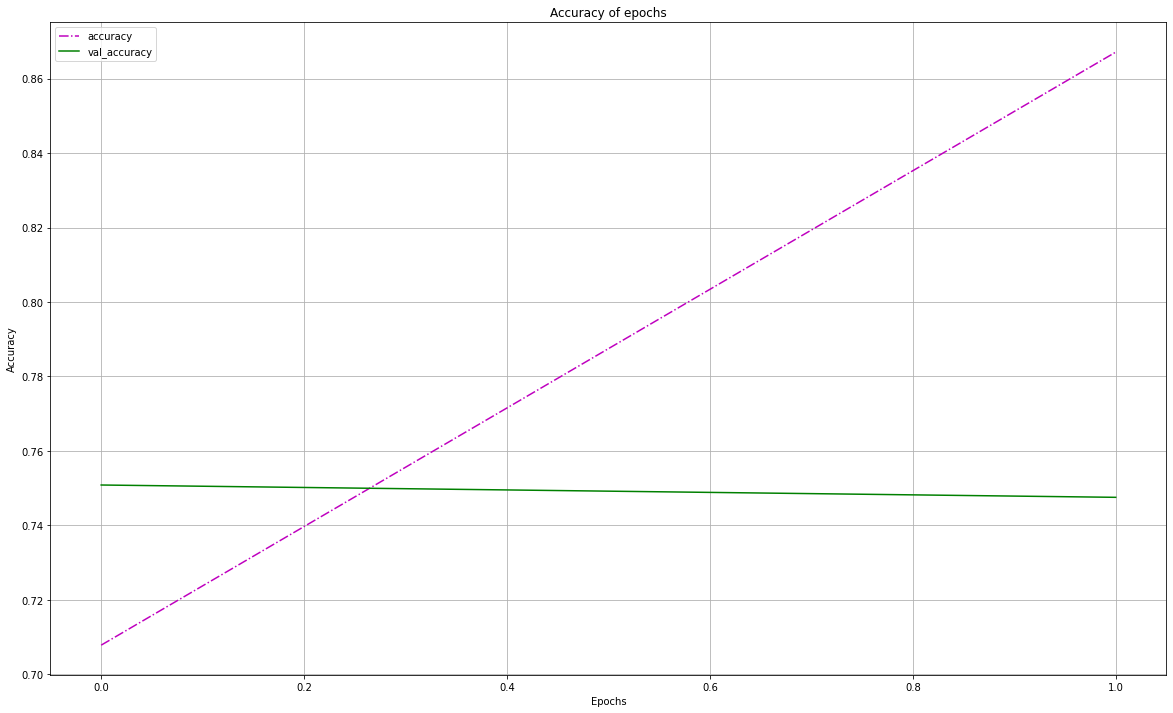

In [24]:
plt.figure(figsize=(20,12))
plt.plot(history.history['accuracy'], '-.', label = f'accuracy', color='m')
plt.plot(history.history['val_accuracy'], '-', label = f'val_accuracy', color='g')
        
plt.legend()
plt.grid('On')
plt.title('Accuracy of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [25]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 11ms/step - loss: 0.5844 - accuracy: 0.7366


Test score: 0.5844288468360901
Test accuracy: 0.73658686876297


In [26]:
result['name'].append('GRU')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### CNN

In [27]:
model = Sequential()
model.add(Embedding(input_dim=word_count, 
                    input_length=training_length, 
                    output_dim=30))

model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])


Epoch 1/10
319/319 [==============================] - 9s 10ms/step - loss: 0.5428 - accuracy: 0.5076 - val_loss: 0.4844 - val_accuracy: 0.5049
Epoch 2/10
319/319 [==============================] - 3s 10ms/step - loss: 0.2891 - accuracy: 0.5076 - val_loss: 0.5441 - val_accuracy: 0.5049


In [29]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.5047


Test score: 0.6017917394638062
Test accuracy: 0.5047392249107361


In [30]:
result['name'].append('CNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### Add Dropout

In [31]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [32]:
model_5.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [33]:
history_5 = model_5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 3s 7ms/step - loss: 0.5797 - accuracy: 0.6836 - val_loss: 0.5120 - val_accuracy: 0.7420
Epoch 2/10
319/319 [==============================] - 2s 6ms/step - loss: 0.4573 - accuracy: 0.7853 - val_loss: 0.4938 - val_accuracy: 0.7529


In [34]:
score = model_5.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

result['name'].append('Add Dropout')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

45/45 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.7355


Test score: 0.5243603587150574
Test accuracy: 0.7354847192764282


### CNN + RNN

In [35]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),

    layers.RepeatVector(1),
    layers.LSTM(64, recurrent_dropout=0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 6s 13ms/step - loss: 0.5821 - accuracy: 0.6815 - val_loss: 0.5188 - val_accuracy: 0.7381
Epoch 2/10
319/319 [==============================] - 4s 12ms/step - loss: 0.4569 - accuracy: 0.7854 - val_loss: 0.4974 - val_accuracy: 0.7529


In [37]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 3ms/step - loss: 0.5470 - accuracy: 0.7361


Test score: 0.5469534993171692
Test accuracy: 0.7361460328102112


In [38]:
result['name'].append('CNN + RNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### GRU + CNN

In [39]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    
    layers.GRU(64, recurrent_dropout=0.2),
    layers.RepeatVector(1),
    layers.GlobalMaxPool1D(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 32s 96ms/step - loss: 0.5531 - accuracy: 0.7049 - val_loss: 0.4908 - val_accuracy: 0.7552
Epoch 2/10
319/319 [==============================] - 30s 95ms/step - loss: 0.3215 - accuracy: 0.8639 - val_loss: 0.5406 - val_accuracy: 0.7485


In [41]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 9ms/step - loss: 0.5957 - accuracy: 0.7380


Test score: 0.595665693283081
Test accuracy: 0.7379975914955139


In [42]:
result['name'].append('GRU + CNN optimizer=adam')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

### Result

In [43]:
df_result = pd.DataFrame(result)
df_result

,name,loss,accuracy
0,SimpleRNN,0.575479,0.738394
1,LSTM,0.598428,0.729886
2,GRU,0.584429,0.736587
3,CNN,0.601792,0.504739
4,Add Dropout,0.524360,0.735485
5,CNN + RNN,0.546953,0.736146
6,GRU + CNN optimizer=adam,0.595666,0.737998


Лучший результат показала GRU+CNN optimizer=Adam - 0.737998